# Copula Pair's Trading Strategy

This notebook demonstrates the usage of the `copula_strategy` module.
The framework is originally proposed in 
- Liew, Rong Qi, and Yuan Wu. "Pairs trading: A copula approach."
- Stander, Yolanda, Daniël Marais, and Ilse Botha. "Trading strategies with copulas."

## A Bare Minimum Intro to Copula

### What Merit Does It Have
Consider having a pair of cointegrated stocks. 
By analyzing their time series, one can calculate their standardized price gap as part of a distance approach, or project their long-run mean as in a cointegrated system as part of a cointegration approach. 
However, none of the two methods are built with the assumptions on distributions from the stocks' time series, which may lead to unused information.
Further, by just using a single parameter (i.e., Euclidean distance) to quantify two coupled time series might fundamentally simplified the problem too much.
The copula model naturally incorporates their marginal distributions, together with other interesting properties from each copula inherited from their own structures, e.g., tail dependency for capturing rare and/or extreme moments like large, cointegrated swings in the market.

Briefly speaking, copula is a tool to capture details of how two random variables are “correlated”.
By having a more detailed modeling framework, we expect the pairs trading strategy followed to be more realistic and robust, and possibly to bring more trading opportunities.

### Definitions for Bivariate Copula
(**Definition using Sklar's Theorem**) For two random variables $S_1$, $S_2 \in [-\infty, \infty]$.
$S_1$ and $S_2$ have their own fixed, continuous CDFs $F_1, F_2$.
Consider their (cumulative) joint distribution $H(s_1, s_2) := P(S_1 \le s_1, S_2 \le s_2)$.
Now take the uniformly distributed quantile random variable $U_1(S_1)$, $U_2(S_2)$, for every pair
$(u_1, u_2)$ drawn from the pair's quantile we define the **bivariate copula**
$C: [0, 1] \times [0, 1] \rightarrow [0, 1]$ as:

$$
    \begin{align}
    C(u_1, u_2) &= P(U_1 \le u_1, U_2 \le u_2) \\
    &= P(S_1 \le F_1^{-1}(u_1), S_2 \le F_2^{-1}(u_2)) \\
    &= H(F_1^{-1}(u_1), F_2^{-1}(u_2))
    \end{align}
$$
where $F_1^{-1}$ and $F_2^{-1}$ are quasi-inverse of the marginal CDFs $F_1$ and $F_2$.
The definition, although mathematically more fundamental, is not used as much in trading.
Instead, cumulative conditional probabilities and copula density are used more often, which we will define as below:
### Cumulative Conditional Probabilities
$$
    \begin{align}
    P(U_1\le u_1 | U_2 = u_2) &:= \frac{\partial C(u_1, u_2)}{\partial u_2}, \\
    P(U_2\le u_2 | U_1 = u_1) &:= \frac{\partial C(u_1, u_2)}{\partial u_1}.
    \end{align}
$$
### Copula Density

$$
    c(u_1 , u_2) := \frac{\partial^2 C(u_1, u_2)}{\partial u_1 \partial u_2},
$$
which by definition is the probability density.

For interested readers, Nelsen's book [An Introduction to Copulas](https://www.springer.com/gp/book/9780387286594) and note [Properties and applications of copulas: Abrief survey](http://w4.stern.nyu.edu/ioms/docs/sg/seminars/nelsen.pdf) present more rigorously and thoroughly on the subject.

## How to Use Copula for Trading

### Use Cumulative Conditional Probabilities
This was originally proposed in [Liew et al., 2013] and [Stander et al., 2013].
We start with a pair of stocks of interest $S_1$ and $S_2$, which can be selected by various methods.
For example, using Engle-Granger test for cointegration.
By consensus, we define the spread as $S_1$ in relation to $S_2$.
e.g. Short the spread means buying $S_1$ and/or selling $S_2$.

Use **cumulative log return** data of the stocks during the training/formation period, we proceed a **pseudo-MLE** fit to establish a copula that reflects the relation of the two stocks during training/formation period.

**Note**: <br>
the type of processed data fed in need to be **approximately stationary** .
i.e., $\mathbb{E}[X(t_1)] \approx \mathbb{E}[X(t_2)]$ for time series $X$, for all $t_1, t_2$ in
the scope of interest.
For example, if we model each stock's price to have a log-Normal distribution, then the price itself cannot be stationary after some time.
Using cumulative log return has the same issue if the time span is sufficiently long.
One can consider just using the daily return or its logarithm instead, given that the stock's price has a log-Normal distribution. i.e., $\frac{X(t+1)}{X(t)}$ or $\ln \left( \frac{X(t+1)}{X(t)} \right)$.

- $u_i \in [0, 1]$ is the quantile of trading period data mapped by a CDF formed in the training period.
- When $P(U_1\le u_1 | U_2 = u_2) < 0.5$, then stock 1 is considered under-valued.
- When $P(U_1\le u_1 | U_2 = u_2) > 0.5$, then stock 1 is considered over-valued.

Now we define an upper threshold $b_{up}$ (e.g. $0.95$) and a lower threshold $b_{lo}$ (e.g. $0.05$),
then the logic goes as follows:

- If $P(U_1\le u_1 | U_2 = u_2) \le b_{lo}$ and $P(U_2\le u_2 | U_1 = u_1) \ge b_{up}$, then stock 1 is
  undervalued, and stock 2 is overvalued. Hence we long the spread.
- If $P(U_2\le u_2 | U_1 = u_1) \le b_{lo}$ and $P(U_1\le u_1 | U_2 = u_2) \ge b_{up}$, then stock 2 is
  undervalued, and stock 1 is overvalued. Hence we short the spread.
- If one of the conditional probabilities cross the boundary of $0.5$ in relation to its previous time step, then we exit the position, as we consider the position is no longer valid.


### `CopulaStrategy` Class Functionalities
Tools presented in this module enable the user to:
* Transform and fit pair's price data to a given type of copula;
* Sample and plot from a given copula;
* Generate trading positions given the pair's data using a copula:
    - Feed in training lists (i.e., data from 2016-2019) and thus generate a position list.
    - Feed in a single pair's data point (i.e., EOD data from just today) and thus generate a single position.

There are 8 commonly used ones that are now available: `Gumbel`, `Frank`, `Clayton`, `Joe`, `N13`, `N14`,
`Gaussian` and `Student` (Student-t).
They are all subclasses of the class `Copula`, and they share some common repertoire of methods and attributes.
However for the most of the time, the user is not expected to directly use the copulas.
All trading related functionalities are stated above, and included in the `CopulaStrategy` class.

The user may choose to fit the pair's data to all provided copulas, then compare the information criterion scores (AIC,
SIC, HQIC) to decide the best copula. One can further use the fitted copula to generate trading positions by giving
thresholds from data.

**Very Important Note**:<br>
For `Student` copula, the user need to provide the degrees of freedom parameter $\nu$, as an extra input argument `nu`.
Use $\nu = \text{sample size} - 1$ is strongly discouraged, as data from time series are clearly not mutual independent instances. For $\nu > 12$, consider using the `Gaussian` copula instead.

### `copula_calculation` Module
To be able to calculate marginal CDFs (quantile function) for plotting purposes or processing other data to be able to feed to some copula, one may use its `find_marginal_cdf` function,
although `ECDF` from `statsmodels.distributions.empirical_distribution` suffices for a general plotting purpose.
This function finds an empirical CDF based on given training data, and does not generate $0$ or $1$, instead gives numbers sufficiently close to $0$ and $1$.
This is done because when some copulas take values in $0$ or $1$, the density and/or margincal conditional probability may become $\infty$.

## Usage
The demonstratration part has the following sections using real world data:
1. Importing and Data Pre-processing.
2. Fitting Data to Different Copulas with Training Data.
3. Generating Trading Positions using Testing Data.
4. Possible Issues Discussion.

### 1. Importing and Data Pre-processing

In [1]:
# Importing libraries and modules
import pandas as pd
import numpy as np
import datetime as dt  # For plotting x-axis as dates
import matplotlib.pyplot as plt
from arbitragelab.copula_approach.copula_strategy import CopulaStrategy
import arbitragelab.copula_approach.copula_calculation as ccalc

For the copula approach to work, the stocks pair need to be cointegrated to begin with.
Here we choose BKD and ESC, the same as the author, and use their daily closing price from the start of 2009 to the end of 2012.
Note that the original price series is not what the copula will use. Instead, we use cumulative return data implied from the price series.

In [2]:
# Importing data and transform them into numpy array
pair_prices = pd.read_csv(r'BKD_ESC_2009_2011.csv')
BKD_series = pair_prices['BKD'].to_numpy()
ESC_series = pair_prices['ESC'].to_numpy()
dates = pair_prices['Date'].to_numpy()
formatted_dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

Now we take a look at the price series for the whole period.
They indeed have cointegrated behavior at first glance.
We then do a training and testing split to fit and simulate trading.

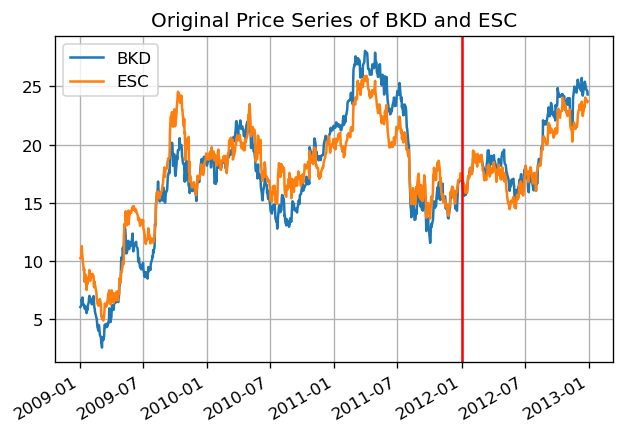

In [3]:
plt.figure(dpi=120)
plt.plot(formatted_dates, BKD_series, label='BKD')
plt.plot(formatted_dates, ESC_series, label='ESC')
plt.axvline(dt.date(2012, 1, 3), color='red')  # Training testing split date
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
plt.title(r'Original Price Series of BKD and ESC')
plt.show()

In [4]:
# Initiate the analysis module
CS = CopulaStrategy()

# Calculate cumulative log return
BKD_clr = CS.cum_log_return(BKD_series)
ESC_clr = CS.cum_log_return(ESC_series)

# Training and testing split
training_length = 756# From 01/02/2009 to 12/30/2011 (m/d/y)

BKD_train = BKD_clr[ : training_length]
ESC_train = ESC_clr[ : training_length]

BKD_test = BKD_clr[training_length : ]
ESC_test = ESC_clr[training_length : ]

# Empirical CDF for the training set.
# This step is necessary for plotting.
cdf1 = ccalc.find_marginal_cdf(BKD_train)
cdf2 = ccalc.find_marginal_cdf(ESC_train)

### 2. Fitting Data to Different Copulas with Training Data.
Here we fit to every copula type available in the module, and print out the scores in terms of SIC, AIC and HQIC. The lower the score (Note they are all negative), the better the fit.

**Note**:<br>
1. `fit_copula` returns the fit result, the fitted copula, and marginal CDFs for the two input lists. Here the `cdf1`, `cdf2` is exactly the same as directly using `find_marginal_cdf` in `copula_calculation` module.
2. For `Student` copula, we are trying $3$ different values for $\nu$. And one can always try more values for $\nu$.

In [5]:
# Fit different copulas, store the results in dictionaries
fit_result_gumbel, copula_gumbel, cdf1, cdf2 =\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Gumbel')

fit_result_frank, copula_frank, cdf1, cdf2 =\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Frank')

fit_result_clayton, copula_clayton, cdf1, cdf2 =\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Clayton')

fit_result_joe, copula_joe, cdf1, cdf2=\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Joe')

fit_result_n13, copula_n13, cdf1, cdf2=\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='N13')

fit_result_n14, copula_n14, cdf1, cdf2=\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='N14')

fit_result_gauss, copula_gauss, cdf1, cdf2 =\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Gaussian')

fit_result_t4, copula_t4, cdf1, cdf2=\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Student', nu=4)

fit_result_t5, copula_t5, cdf1, cdf2 =\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Student', nu=5)

fit_result_t8, copula_t8, cdf1, cdf2 =\
    CS.fit_copula(s1_series=BKD_train, s2_series=ESC_train, copula_name='Student', nu=8)

In [6]:
# print all the fit scores
print(fit_result_gumbel)
print(fit_result_frank)
print(fit_result_clayton)
print(fit_result_joe)
print(fit_result_n13)
print(fit_result_n14)
print(fit_result_gauss)
print(fit_result_t4)
print(fit_result_t5)
print(fit_result_t8)

{'Copula Name': 'Gumbel', 'SIC': -1450.7952464332018, 'AIC': -1455.4179827695934, 'HQIC': -1453.6406691250231}
{'Copula Name': 'Frank', 'SIC': -1598.5589756582913, 'AIC': -1603.181711994683, 'HQIC': -1601.4043983501126}
{'Copula Name': 'Clayton', 'SIC': -1643.0112976940648, 'AIC': -1647.6340340304564, 'HQIC': -1645.856720385886}
{'Copula Name': 'Joe', 'SIC': -593.3513974011638, 'AIC': -597.9741337375556, 'HQIC': -596.1968200929853}
{'Copula Name': 'N13', 'SIC': -1792.3636621012058, 'AIC': -1796.9863984375975, 'HQIC': -1795.2090847930272}
{'Copula Name': 'N14', 'SIC': -1555.5351104717956, 'AIC': -1560.1578468081873, 'HQIC': -1558.380533163617}
{'Copula Name': 'Gaussian', 'SIC': -1713.362919801625, 'AIC': -1717.9856561380166, 'HQIC': -1716.2083424934463}
{'Copula Name': 'Student', 'SIC': -1737.1403802758616, 'AIC': -1741.7631166122533, 'HQIC': -1739.985802967683}
{'Copula Name': 'Student', 'SIC': -1746.669614731534, 'AIC': -1751.2923510679257, 'HQIC': -1749.5150374233554}
{'Copula Name':

It seems by the score, N13 and Student-t with $\nu=5$ are reasonable choices of copula that fit our training data the best.
So at first, we take a look at their information.

In [7]:
print(copula_n13.describe(if_print=False), '\n')
print(copula_t5.describe(if_print=False))

Descriptive Name    Bivariate Nelsen 13 Copula
Class Name                                 N13
theta                                  14.1743
dtype: object 

Descriptive Name                                  Bivariate Student-t Copula
Class Name                                                           Student
cov                        [[1.8888437660376143, 1.7933765614849653], [1....
rho                                                                 0.950831
nu (degrees of freedom)                                                    5
dtype: object


Now we plot the training data (as an empirical copula), together with $5$ other copulas fitted.

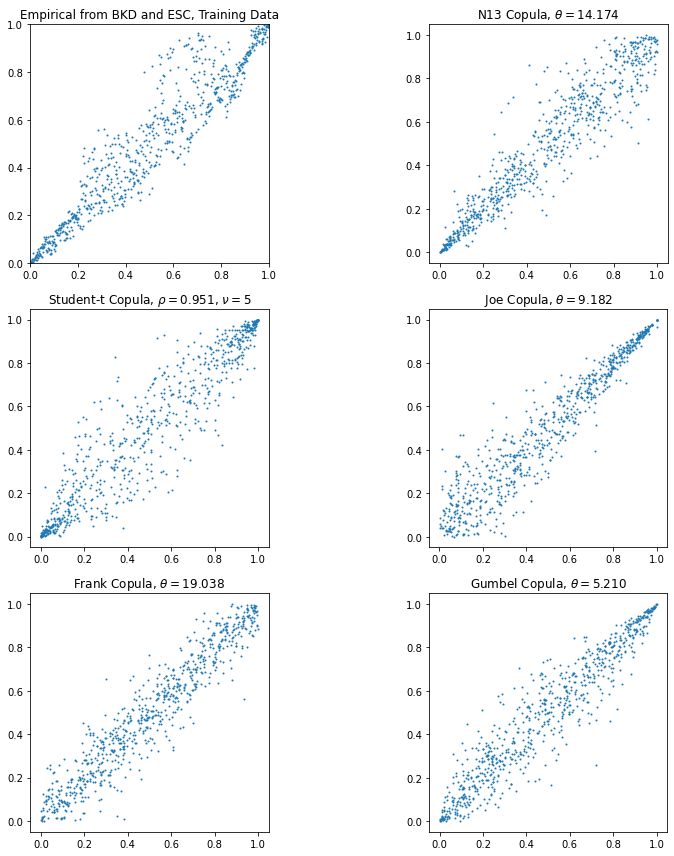

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
# axs[0, 0]: Empirical.
axs[0, 0].scatter(cdf1(BKD_train), cdf2(ESC_train), s=1)
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_title(r'Empirical from BKD and ESC, Training Data')
axs[0, 0].set_xlim([0,1])
axs[0, 0].set_ylim([0,1])

# axs[0, 1]: N13.
CS.graph_copula(copula_name='N13', theta=copula_n13.theta,
                ax=axs[0, 1], s=1, num=len(ESC_train))

# axs[1, 0]: Student-t, nu=5.
CS.graph_copula(copula_name='Student', cov=copula_t5.cov, nu=copula_t5.nu,
                ax=axs[1, 0], s=1, num=len(ESC_train))
# axs[1, 1]: Joe.
CS.graph_copula(copula_name='Joe', theta=copula_joe.theta,
                ax=axs[1, 1], s=1, num=len(ESC_train))
# axs[2, 0]: Frank.
CS.graph_copula(copula_name='Frank', theta=copula_frank.theta,
                ax=axs[2, 0], s=1, num=len(ESC_train))
# axs[2, 1]: Gumbel.
CS.graph_copula(copula_name='Gumbel', theta=copula_gumbel.theta,
                ax=axs[2, 1], s=1, num=len(ESC_train))

plt.tight_layout()
plt.show()

### 3. Generate Trading Positions Using Test Data
At first we plot the testing data (as an empirical copula) and the two chosen copulas, together with three other copulas fitted.

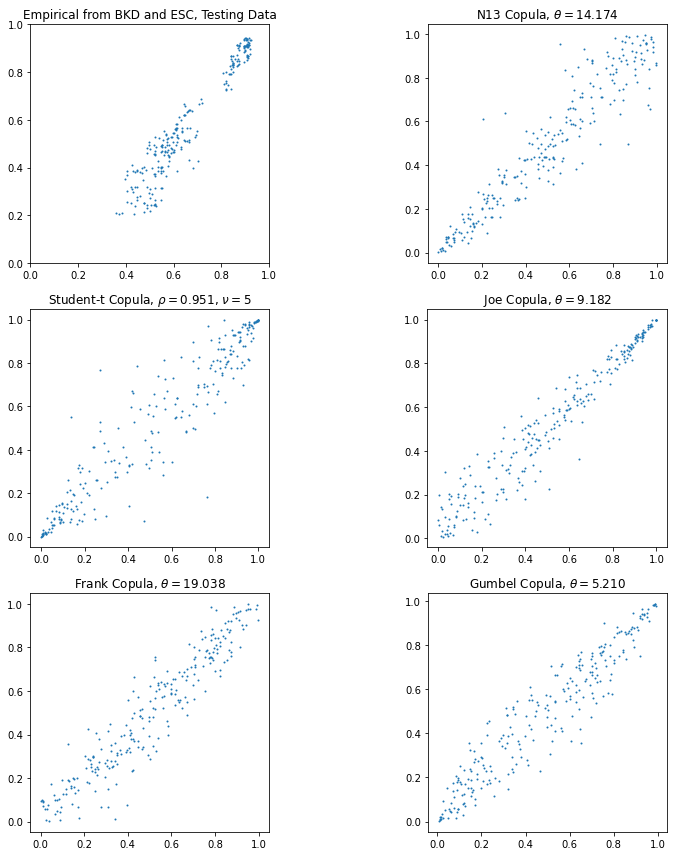

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
# axs[0, 0]: Empirical.
axs[0, 0].scatter(cdf1(BKD_test), cdf2(ESC_test), s=1)
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_title(r'Empirical from BKD and ESC, Testing Data')
axs[0, 0].set_xlim([0,1])
axs[0, 0].set_ylim([0,1])

# axs[0, 1]: N13.
CS.graph_copula(copula_name='N13', theta=copula_n13.theta,
                ax=axs[0, 1], s=1, num=len(ESC_test))

# axs[1, 0]: Student-t, nu=5.
CS.graph_copula(copula_name='Student', cov=copula_t5.cov, nu=copula_t5.nu,
                ax=axs[1, 0], s=1, num=len(ESC_test))
# axs[1, 1]: Joe.
CS.graph_copula(copula_name='Joe', theta=copula_joe.theta,
                ax=axs[1, 1], s=1, num=len(ESC_test))
# axs[2, 0]: Frank.
CS.graph_copula(copula_name='Frank', theta=copula_frank.theta,
                ax=axs[2, 0], s=1, num=len(ESC_test))
# axs[2, 1]: Gumbel.
CS.graph_copula(copula_name='Gumbel', theta=copula_gumbel.theta,
                ax=axs[2, 1], s=1, num=len(ESC_test))

plt.tight_layout()
plt.show()

Also, one can run an information test with the fitted copulas using test data.
This is a necessary step to see how consistent or robust the chosen copula model is.
If the answer changes greatly from the training data, there are several possibilities, for example:
* Testing data differ significantly from training data in terms of distributions, although they are still cointegrated.
* The two stocks should be modeled by another copula that is not included in this module.
* Market has fundamentally changed and as a result the two stocks have decoupled.

As a rule of thumb, it is always a good practice to look at multiple models instead of using only one, especially when the outcome is quite sensitive to inputs.

As can be seen from the outputs below, N13 is no longer the best copula to describe the test data.

In [10]:
# Running information tests for the test data with the fitted copula
test_ic_n13 = CS.ic_test(BKD_test, ESC_test, cdf1, cdf2, copula=copula_n13)
test_ic_t5 = CS.ic_test(BKD_test, ESC_test, cdf1, cdf2, copula=copula_t5)
print(test_ic_n13)
print(test_ic_t5)

{'Copula Name': 'N13', 'SIC': -378.2325671960598, 'AIC': -381.7338257605407, 'HQIC': -380.33418744853105}
{'Copula Name': 'Student', 'SIC': -482.5977346158932, 'AIC': -486.0989931803741, 'HQIC': -484.6993548683645}


Then we get trading positions from the two chosen copulas.

**Note**:<br>
Although theoretically one can change the threshold to potentially bring more trading opportunities, it needs to proceed with caution, as the recommended positions are very sensitive to the choice of copula and training data if the thresholds are not as strict.

In [11]:
# Generate Trading Positions
# Use N13 copula.
# Instantiate the CopulaStrategy with the fitted N13 copula.
CS_n13 = CopulaStrategy(copula=copula_n13)
positions_n13 = CS_n13.analyze_time_series(BKD_test, ESC_test, cdf1, cdf2,
                                           upper_threshold=0.95,
                                           lower_threshold=0.05,
                                           start_position=0)  # Author used 0.95 and 0.05

# Use Student-t Copula with DOF=5.
# Instantiate the CopulaStrategy with the fitted Student-t copula.
CS_t5 = CopulaStrategy(copula=copula_t5)
positions_t5 = CS_t5.analyze_time_series(BKD_test, ESC_test, cdf1, cdf2,
                                         upper_threshold=0.95,
                                         lower_threshold=0.05,
                                         start_position=0)

Plot trading positions with recalculated cumulative log return (CLR) from test data, with the starting reference day as day 1 in the test data.

Here, 0 means no position, 1 means long the spread, -1 means short the spread.

**Note**:<br>
This is not the same as cumulative log returns used in the test data.
Suppose the training/testing split happens at day $755$, then the CLR is still calculated as $\ln(S(t))-\ln(S(0))$ for $t>755$.
However, we are plotting $\ln(S(t))-\ln(S(756))$, so that it is easier to see the spread and evaluate our recommended trading positions.
It is thus can be understood as a *repositioned log price*, or *reset cumulative log return*.

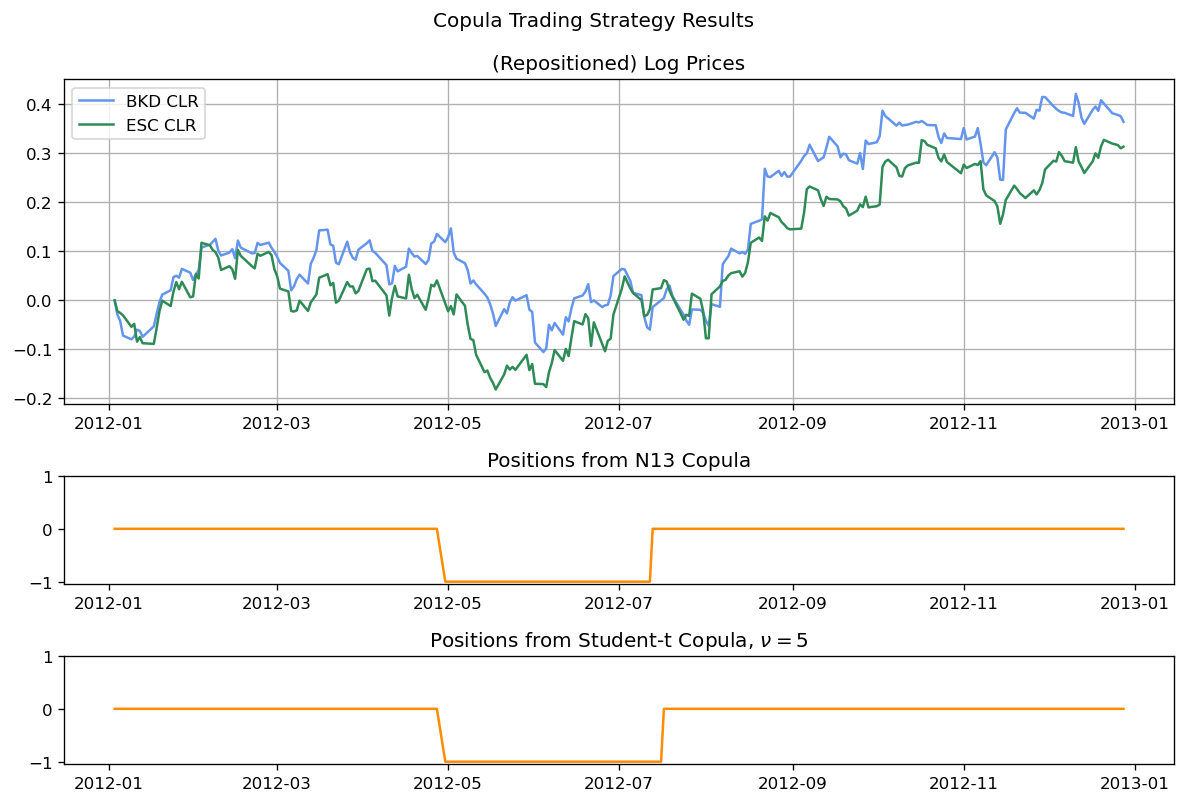

In [12]:
formatted_dates_test = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates[training_length : ]]

fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1, 1]}, figsize=(10,7), dpi=120)
fig.suptitle('Copula Trading Strategy Results')
# Plotting repositioned log prices
axs[0].plot(formatted_dates_test, BKD_test-BKD_test[0], label='BKD CLR', color='cornflowerblue')
axs[0].plot(formatted_dates_test, ESC_test-ESC_test[0], label='ESC CLR', color='seagreen')
axs[0].title.set_text('(Repositioned) Log Prices')
axs[0].legend()
axs[0].grid()
# Plotting positions from N13
axs[1].plot(formatted_dates_test, positions_n13, label='Positions', color='darkorange')
axs[1].title.set_text('Positions from N13 Copula')
axs[1].set_yticks([-1,0,1])
# Plotting positions from Student-t, DOF=5
axs[2].plot(formatted_dates_test, positions_t5, label='Positions', color='darkorange')
axs[2].title.set_text(r'Positions from Student-t Copula, $\nu=5$')
axs[2].set_yticks([-1,0,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Avoid title overlap
plt.show()

### 4. Possible Issues Discussion

#### Data Processing
Log prices or CLR are not fundamentally stationary, and especially in real data, the training period may differ significantly from testing period, rendering tesing period data out of range.
One may consider other alternatives.

#### Copula Fitting
The fitting results are very sensitive to the inputs.
And more often than not, the fit score among copulas are not very different from each other.
In this case, one should look at the few best suited copulas as candidates, instead of using a single copula.

#### Copula Modeling
Modeling and trading a pair of stocks' movements using copula, as implemented in the module, treats each stocks time series data as a random variable with stationary distribution.
Though mathematically valid, this approach does not take into account of each random variable as a time series, and re-shuffle the training data will yield the exact same result in terms fitted copula parameters and thus recommended positions.
However, when compared to a vanilla Euclidean distance approach, this is one step further.

Moreover, all the commonly used copulas are either Archimedean (Gumbel, Frank, etc.) or Elliptic (Student-t, Gaussian), which share some nice properties such as symmetry.
However, the best suited copula behind a pair of stocks may not necessarily be symmetric.

## Conclusion
(This section follows from [Liew et al. 2013])<br>
Copula introduces delicate assumptions on the exact coupled structure, along with other nice properties, of two random variables.
In the pairs trading context, two stocks time series.

* When compared to Euclidean distance or cointegration approach, copula does not rely on assumptions of linear association or corelation coefficients as measure of dependency.

* Copula-based approach results in a far richer set of information, such as the shape and nature of the dependency between the stock pairs, thereby leading to potentially more robust modeling of the pair.

* Some copula choices measure well with upper and lower tail dependencies of different extent, in an environment that considers both linear and non-linear relationship. 

* Copulas possess an attractive property of being invariant under strictly monotone transformations of random variables. In other words, the same copula will be obtained regardless of whether the analyst is using price series or log price series.

## References ##
- Liew, R.Q. and Wu, Y., 2013. Pairs trading: A copula approach. Journal of Derivatives & Hedge Funds, 19(1), pp.12-30.
- Stander, Y., Marais, D. and Botha, I., 2013. Trading strategies with copulas. Journal of Economic and Financial Sciences, 6(1), pp.83-107.